In [1]:
import tensorflow as tf
import scipy.io as io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load Data

In [2]:
def loadData():
    data = io.loadmat("face_landmark.mat")
    images = data["images"]
    landmarks = data["landmarks"]
    print("im_shape:", images.shape)
    print("landmarks_shape:", landmarks.shape)

    return images, landmarks

In [3]:
images, landmarks = loadData()

im_shape: (2140, 96, 96)
landmarks_shape: (2140, 15, 2)


# Visualize Data

In [4]:
def visualize_data(images, landmarks, num_images):
    fig = plt.figure(figsize=(10,10))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

    for i in range(num_images):
        ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
        ax.imshow(images[i], cmap='gray')
        for (x, y) in landmarks[i].reshape(-1, 2):
            # Plot keypoints/landmarks on the image
            ax.scatter(x, y, marker='o', s=10, color='r')

    plt.show()

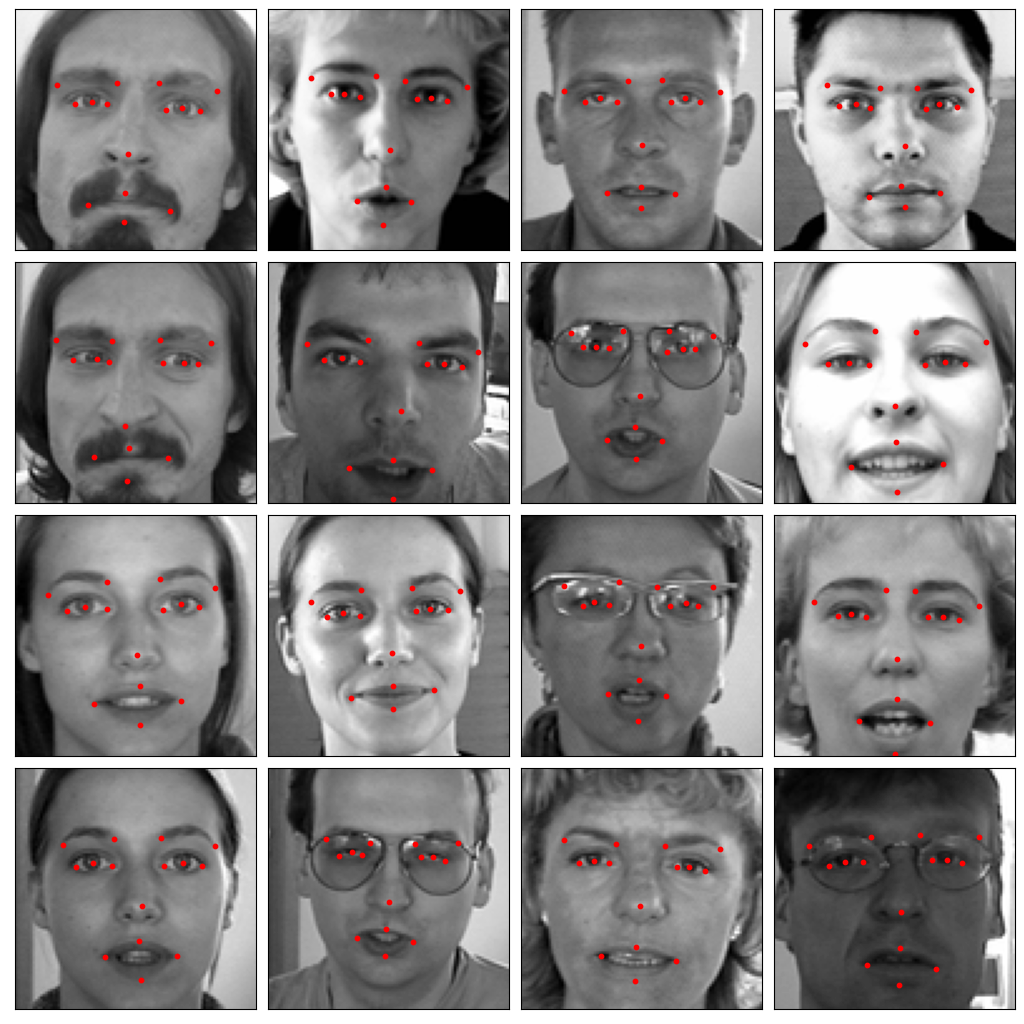

In [5]:
visualize_data(images, landmarks, num_images=16)

# Preprocessing

### split

In [6]:
def split_data(data, size):
    np.random.seed(2023)
    
    idx = np.random.permutation(size)

    train_size = int(size * 0.6)
    val_size = int(size * 0.2)
    test_size = int(size * 0.2)

    train_ds = data[idx[: train_size]]
    val_ds = data[idx[train_size: train_size + val_size]]
    test_ds = data[idx[size - test_size:]]

    return train_ds, val_ds, test_ds

In [7]:
train_img, val_img, test_img = split_data(images, images.shape[0])

In [8]:
train_lmrk, val_lmrk, test_lmrk = split_data(landmarks, landmarks.shape[0])

### Reshape

In [9]:
print(train_img.shape)
print(train_lmrk.shape)

(1284, 96, 96)
(1284, 15, 2)


In [10]:
print(val_img.shape)
print(val_lmrk.shape)

(428, 96, 96)
(428, 15, 2)


In [11]:
print(test_img.shape)
print(test_lmrk.shape)

(428, 96, 96)
(428, 15, 2)


In [12]:
train_lmrk = train_lmrk.reshape((1284, -1))
val_lmrk = val_lmrk.reshape((428, -1))
test_lmrk = test_lmrk.reshape((428, -1))

In [13]:
print(train_lmrk.shape)
print(val_lmrk.shape)
print(test_lmrk.shape)

(1284, 30)
(428, 30)
(428, 30)


# Model
* Output은 15개의 얼굴 랜드마크에 해당하는 x, y 좌표이므로 총 30개의 출력 유닛이 필요

In [14]:
# Define the input shape
input_layer = tf.keras.Input(shape=(96, 96, 1))

# Define the convolution and pooling layers
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)

# Flatten the tensor output for the Fully Connected layer
x = tf.keras.layers.Flatten()(x)

# Define the fully connected layer
x = tf.keras.layers.Dense(64, activation='relu')(x)

# Define the output layer (30 units for 15 landmarks x and y coordinates)
output_layer = tf.keras.layers.Dense(30)(x)

# Create the model
model = tf.keras.Model(input_layer, output_layer)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 45, 45, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 22, 22, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 64)        18496 

## Predict

In [15]:
@tf.function
def predict(x):
    return model(x, training=False)

# Optimization

In [16]:
@tf.function
def optimize(x,y_true,loss_function):
    with tf.GradientTape() as tape:
        y_pred = predict(x)
        loss = loss_function(y_pred, y_true)
    grads = tape.gradient(loss, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [17]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3)

# Loss
* 실제 레이블(y_true)와 모델의 예측 결과(y)를 입력

In [18]:
@tf.function
def l1_loss(y_pred, y_true):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

@tf.function
def l2_loss(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_true - y_pred))

@tf.function
def cosine_loss(y_pred, y_true):
    # Normalize each vector
    y_true_normalized = tf.nn.l2_normalize(y_true, axis=-1)
    y_pred_normalized = tf.nn.l2_normalize(y_pred, axis=-1)
    # Compute the dot product (cosine similarity)
    dot_product = tf.reduce_sum(y_true_normalized * y_pred_normalized, axis=-1)
    # Subtract the dot product from 1 to get the loss
    return 1 - tf.reduce_mean(dot_product)


In [19]:
def combine_l2_loss(y_pred, y_true, lamda):
    return l2_loss(y_pred, y_true) + lamda*cosine_loss(y_pred, y_true)

# Train & Evaluation

## Cosine Loss

In [20]:
""" start training """
loss_function = cosine_loss

max_epochs = 1000
batch_size = 32


loss_history = []
val_loss_best = np.inf
train_size = int(images.shape[0] * 0.6)

#Early stopping hyperparameter
patience = 50  # number of epochs to wait before stopping if there is no improvement
wait = 0  # counter for epochs without improvement


for epoch in range(max_epochs):
    # get a minibatch
    idx = np.random.permutation(train_size)
    batch_idx = idx[:batch_size]

    # optimize
    train_loss = optimize(train_img[batch_idx], train_lmrk[batch_idx], loss_function)
    train_loss = train_loss.numpy()

    # evaluate on val_set
    y = predict(val_img)
    val_loss = loss_function(y, val_lmrk).numpy()

    # Early stopping check
    if val_loss < val_loss_best:
        val_loss_best = val_loss
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f'Early stopping on epoch {epoch}')
            break
        
    print('Epoch:', epoch, '. Training Loss:', train_loss, ' Validation Loss:', val_loss, ' Best Validation Loss:', val_loss_best)
    loss_history.append([train_loss, val_loss])

Epoch: 0 . Training Loss: 0.75314456  Validation Loss: 0.36462098  Best Validation Loss: 0.36462098
Epoch: 1 . Training Loss: 0.36180985  Validation Loss: 0.22351521  Best Validation Loss: 0.22351521
Epoch: 2 . Training Loss: 0.22221667  Validation Loss: 0.17215896  Best Validation Loss: 0.17215896
Epoch: 3 . Training Loss: 0.17085469  Validation Loss: 0.13244921  Best Validation Loss: 0.13244921
Epoch: 4 . Training Loss: 0.13350534  Validation Loss: 0.11062211  Best Validation Loss: 0.11062211
Epoch: 5 . Training Loss: 0.110007346  Validation Loss: 0.097412705  Best Validation Loss: 0.097412705
Epoch: 6 . Training Loss: 0.098050475  Validation Loss: 0.0814926  Best Validation Loss: 0.0814926
Epoch: 7 . Training Loss: 0.08238095  Validation Loss: 0.06717944  Best Validation Loss: 0.06717944
Epoch: 8 . Training Loss: 0.067549884  Validation Loss: 0.057807148  Best Validation Loss: 0.057807148
Epoch: 9 . Training Loss: 0.05684352  Validation Loss: 0.051195085  Best Validation Loss: 0.051

Epoch: 79 . Training Loss: 0.0018294454  Validation Loss: 0.0018833876  Best Validation Loss: 0.001880765
Epoch: 80 . Training Loss: 0.0018797517  Validation Loss: 0.0018872619  Best Validation Loss: 0.001880765
Epoch: 81 . Training Loss: 0.0018235445  Validation Loss: 0.001881659  Best Validation Loss: 0.001880765
Epoch: 82 . Training Loss: 0.0019396544  Validation Loss: 0.0018705726  Best Validation Loss: 0.0018705726
Epoch: 83 . Training Loss: 0.0018993616  Validation Loss: 0.001863718  Best Validation Loss: 0.001863718
Epoch: 84 . Training Loss: 0.001644969  Validation Loss: 0.0018572807  Best Validation Loss: 0.0018572807
Epoch: 85 . Training Loss: 0.0019478798  Validation Loss: 0.0018597245  Best Validation Loss: 0.0018572807
Epoch: 86 . Training Loss: 0.0015617013  Validation Loss: 0.0018674731  Best Validation Loss: 0.0018572807
Epoch: 87 . Training Loss: 0.0020982623  Validation Loss: 0.0018648505  Best Validation Loss: 0.0018572807
Epoch: 88 . Training Loss: 0.002593398  Vali

Epoch: 156 . Training Loss: 0.0015923977  Validation Loss: 0.0016286969  Best Validation Loss: 0.0016286969
Epoch: 157 . Training Loss: 0.0014864206  Validation Loss: 0.0016188622  Best Validation Loss: 0.0016188622
Epoch: 158 . Training Loss: 0.001193285  Validation Loss: 0.0016298294  Best Validation Loss: 0.0016188622
Epoch: 159 . Training Loss: 0.0023235083  Validation Loss: 0.0016326904  Best Validation Loss: 0.0016188622
Epoch: 160 . Training Loss: 0.0018666983  Validation Loss: 0.0016117692  Best Validation Loss: 0.0016117692
Epoch: 161 . Training Loss: 0.0015186667  Validation Loss: 0.0016120076  Best Validation Loss: 0.0016117692
Epoch: 162 . Training Loss: 0.0018694401  Validation Loss: 0.0016424656  Best Validation Loss: 0.0016117692
Epoch: 163 . Training Loss: 0.0015927553  Validation Loss: 0.0016480684  Best Validation Loss: 0.0016117692
Epoch: 164 . Training Loss: 0.0016183853  Validation Loss: 0.0016195774  Best Validation Loss: 0.0016117692
Epoch: 165 . Training Loss: 0

Epoch: 233 . Training Loss: 0.0013285875  Validation Loss: 0.0015131831  Best Validation Loss: 0.0015069246
Epoch: 234 . Training Loss: 0.0013177395  Validation Loss: 0.0015140176  Best Validation Loss: 0.0015069246
Epoch: 235 . Training Loss: 0.001372695  Validation Loss: 0.0015060306  Best Validation Loss: 0.0015060306
Epoch: 236 . Training Loss: 0.0015400648  Validation Loss: 0.0015081763  Best Validation Loss: 0.0015060306
Epoch: 237 . Training Loss: 0.0019310713  Validation Loss: 0.0015206933  Best Validation Loss: 0.0015060306
Epoch: 238 . Training Loss: 0.0013126731  Validation Loss: 0.0015230179  Best Validation Loss: 0.0015060306
Epoch: 239 . Training Loss: 0.0021691322  Validation Loss: 0.0015154481  Best Validation Loss: 0.0015060306
Epoch: 240 . Training Loss: 0.0012184381  Validation Loss: 0.0015113354  Best Validation Loss: 0.0015060306
Epoch: 241 . Training Loss: 0.0013979673  Validation Loss: 0.0015134215  Best Validation Loss: 0.0015060306
Epoch: 242 . Training Loss: 0

Epoch: 310 . Training Loss: 0.00109905  Validation Loss: 0.0014535785  Best Validation Loss: 0.0014451742
Epoch: 311 . Training Loss: 0.001457274  Validation Loss: 0.0014554858  Best Validation Loss: 0.0014451742
Epoch: 312 . Training Loss: 0.0011504292  Validation Loss: 0.0014469028  Best Validation Loss: 0.0014451742
Epoch: 313 . Training Loss: 0.00094127655  Validation Loss: 0.0014422536  Best Validation Loss: 0.0014422536
Epoch: 314 . Training Loss: 0.0014562607  Validation Loss: 0.0014406443  Best Validation Loss: 0.0014406443
Epoch: 315 . Training Loss: 0.0014975667  Validation Loss: 0.001444459  Best Validation Loss: 0.0014406443
Epoch: 316 . Training Loss: 0.0014697313  Validation Loss: 0.0014510751  Best Validation Loss: 0.0014406443
Epoch: 317 . Training Loss: 0.0010341406  Validation Loss: 0.0014518499  Best Validation Loss: 0.0014406443
Epoch: 318 . Training Loss: 0.0010912418  Validation Loss: 0.001454711  Best Validation Loss: 0.0014406443
Epoch: 319 . Training Loss: 0.00

Epoch: 387 . Training Loss: 0.001164794  Validation Loss: 0.0014036894  Best Validation Loss: 0.0014036894
Epoch: 388 . Training Loss: 0.0013817549  Validation Loss: 0.0013946295  Best Validation Loss: 0.0013946295
Epoch: 389 . Training Loss: 0.0011250973  Validation Loss: 0.0014092922  Best Validation Loss: 0.0013946295
Epoch: 390 . Training Loss: 0.0015200377  Validation Loss: 0.0014092326  Best Validation Loss: 0.0013946295
Epoch: 391 . Training Loss: 0.0014307499  Validation Loss: 0.0014096498  Best Validation Loss: 0.0013946295
Epoch: 392 . Training Loss: 0.0012639165  Validation Loss: 0.0013985038  Best Validation Loss: 0.0013946295
Epoch: 393 . Training Loss: 0.001565218  Validation Loss: 0.0013799667  Best Validation Loss: 0.0013799667
Epoch: 394 . Training Loss: 0.0012401342  Validation Loss: 0.0013849139  Best Validation Loss: 0.0013799667
Epoch: 395 . Training Loss: 0.0011567473  Validation Loss: 0.001392901  Best Validation Loss: 0.0013799667
Epoch: 396 . Training Loss: 0.0

Epoch: 464 . Training Loss: 0.0014107227  Validation Loss: 0.0013508201  Best Validation Loss: 0.0013299584
Epoch: 465 . Training Loss: 0.0013076067  Validation Loss: 0.0013837218  Best Validation Loss: 0.0013299584
Epoch: 466 . Training Loss: 0.0014548302  Validation Loss: 0.0013577938  Best Validation Loss: 0.0013299584
Epoch: 467 . Training Loss: 0.0013118386  Validation Loss: 0.0013571978  Best Validation Loss: 0.0013299584
Epoch: 468 . Training Loss: 0.0015393496  Validation Loss: 0.0013698936  Best Validation Loss: 0.0013299584
Epoch: 469 . Training Loss: 0.0016769171  Validation Loss: 0.0013545156  Best Validation Loss: 0.0013299584
Epoch: 470 . Training Loss: 0.0015749335  Validation Loss: 0.0013290644  Best Validation Loss: 0.0013290644
Epoch: 471 . Training Loss: 0.0014894009  Validation Loss: 0.0013328791  Best Validation Loss: 0.0013290644
Epoch: 472 . Training Loss: 0.0014059544  Validation Loss: 0.0013489723  Best Validation Loss: 0.0013290644
Epoch: 473 . Training Loss: 

Epoch: 541 . Training Loss: 0.0009992719  Validation Loss: 0.0012893677  Best Validation Loss: 0.0012893677
Epoch: 542 . Training Loss: 0.0010693073  Validation Loss: 0.00128901  Best Validation Loss: 0.00128901
Epoch: 543 . Training Loss: 0.0010529757  Validation Loss: 0.0012879968  Best Validation Loss: 0.0012879968
Epoch: 544 . Training Loss: 0.0012108088  Validation Loss: 0.0012881756  Best Validation Loss: 0.0012879968
Epoch: 545 . Training Loss: 0.0011389256  Validation Loss: 0.001283586  Best Validation Loss: 0.001283586
Epoch: 546 . Training Loss: 0.0014197826  Validation Loss: 0.0012936592  Best Validation Loss: 0.001283586
Epoch: 547 . Training Loss: 0.001292944  Validation Loss: 0.0013105273  Best Validation Loss: 0.001283586
Epoch: 548 . Training Loss: 0.0010516047  Validation Loss: 0.0013071299  Best Validation Loss: 0.001283586
Epoch: 549 . Training Loss: 0.0010565519  Validation Loss: 0.0012978315  Best Validation Loss: 0.001283586
Epoch: 550 . Training Loss: 0.001398384

Epoch: 618 . Training Loss: 0.0010995269  Validation Loss: 0.0012487769  Best Validation Loss: 0.0012455583
Epoch: 619 . Training Loss: 0.0012949109  Validation Loss: 0.0012418628  Best Validation Loss: 0.0012418628
Epoch: 620 . Training Loss: 0.0011421442  Validation Loss: 0.0012405515  Best Validation Loss: 0.0012405515
Epoch: 621 . Training Loss: 0.0010815859  Validation Loss: 0.0012519956  Best Validation Loss: 0.0012405515
Epoch: 622 . Training Loss: 0.0012096763  Validation Loss: 0.001260817  Best Validation Loss: 0.0012405515
Epoch: 623 . Training Loss: 0.0012943745  Validation Loss: 0.001247108  Best Validation Loss: 0.0012405515
Epoch: 624 . Training Loss: 0.00091314316  Validation Loss: 0.0012338161  Best Validation Loss: 0.0012338161
Epoch: 625 . Training Loss: 0.0008504391  Validation Loss: 0.0012306571  Best Validation Loss: 0.0012306571
Epoch: 626 . Training Loss: 0.0014167428  Validation Loss: 0.0012366772  Best Validation Loss: 0.0012306571
Epoch: 627 . Training Loss: 0

Epoch: 695 . Training Loss: 0.0013920069  Validation Loss: 0.0012251735  Best Validation Loss: 0.0012111068
Epoch: 696 . Training Loss: 0.0009454489  Validation Loss: 0.001204133  Best Validation Loss: 0.001204133
Epoch: 697 . Training Loss: 0.0011413097  Validation Loss: 0.0011914968  Best Validation Loss: 0.0011914968
Epoch: 698 . Training Loss: 0.0011981726  Validation Loss: 0.0012067556  Best Validation Loss: 0.0011914968
Epoch: 699 . Training Loss: 0.0008071661  Validation Loss: 0.0012069345  Best Validation Loss: 0.0011914968
Epoch: 700 . Training Loss: 0.001095295  Validation Loss: 0.00120157  Best Validation Loss: 0.0011914968
Epoch: 701 . Training Loss: 0.0013878345  Validation Loss: 0.001204431  Best Validation Loss: 0.0011914968
Epoch: 702 . Training Loss: 0.001016736  Validation Loss: 0.0012094975  Best Validation Loss: 0.0011914968
Epoch: 703 . Training Loss: 0.0010224581  Validation Loss: 0.0012072325  Best Validation Loss: 0.0011914968
Epoch: 704 . Training Loss: 0.00106

Epoch: 772 . Training Loss: 0.0011693239  Validation Loss: 0.0011790395  Best Validation Loss: 0.0011599064
Epoch: 773 . Training Loss: 0.0010157824  Validation Loss: 0.0011625886  Best Validation Loss: 0.0011599064
Epoch: 774 . Training Loss: 0.00096547604  Validation Loss: 0.0011726618  Best Validation Loss: 0.0011599064
Epoch: 775 . Training Loss: 0.0009470582  Validation Loss: 0.0011715889  Best Validation Loss: 0.0011599064
Epoch: 776 . Training Loss: 0.0011862516  Validation Loss: 0.0011667013  Best Validation Loss: 0.0011599064
Epoch: 777 . Training Loss: 0.0009557009  Validation Loss: 0.0011743307  Best Validation Loss: 0.0011599064
Epoch: 778 . Training Loss: 0.0012900233  Validation Loss: 0.0011672378  Best Validation Loss: 0.0011599064
Epoch: 779 . Training Loss: 0.0012322664  Validation Loss: 0.0011637807  Best Validation Loss: 0.0011599064
Epoch: 780 . Training Loss: 0.001034975  Validation Loss: 0.0011638999  Best Validation Loss: 0.0011599064
Epoch: 781 . Training Loss: 

Epoch: 848 . Training Loss: 0.0009875298  Validation Loss: 0.0011433959  Best Validation Loss: 0.0011278391
Epoch: 849 . Training Loss: 0.0009021759  Validation Loss: 0.0011695623  Best Validation Loss: 0.0011278391
Epoch: 850 . Training Loss: 0.00094127655  Validation Loss: 0.0011677146  Best Validation Loss: 0.0011278391
Epoch: 851 . Training Loss: 0.0011283755  Validation Loss: 0.0011314154  Best Validation Loss: 0.0011278391
Epoch: 852 . Training Loss: 0.0011125803  Validation Loss: 0.0011433959  Best Validation Loss: 0.0011278391
Epoch: 853 . Training Loss: 0.0012402534  Validation Loss: 0.0011559725  Best Validation Loss: 0.0011278391
Epoch: 854 . Training Loss: 0.0009357929  Validation Loss: 0.0011358261  Best Validation Loss: 0.0011278391
Epoch: 855 . Training Loss: 0.0012220144  Validation Loss: 0.0011358261  Best Validation Loss: 0.0011278391
Epoch: 856 . Training Loss: 0.00080013275  Validation Loss: 0.0011328459  Best Validation Loss: 0.0011278391
Epoch: 857 . Training Loss

Epoch: 924 . Training Loss: 0.00092864037  Validation Loss: 0.0011023879  Best Validation Loss: 0.001098752
Epoch: 925 . Training Loss: 0.00080138445  Validation Loss: 0.0011034608  Best Validation Loss: 0.001098752
Epoch: 926 . Training Loss: 0.0009742379  Validation Loss: 0.0011017919  Best Validation Loss: 0.001098752
Epoch: 927 . Training Loss: 0.0010169744  Validation Loss: 0.001101315  Best Validation Loss: 0.001098752
Epoch: 928 . Training Loss: 0.0013384223  Validation Loss: 0.0011027455  Best Validation Loss: 0.001098752
Epoch: 929 . Training Loss: 0.0008364916  Validation Loss: 0.0010963678  Best Validation Loss: 0.0010963678
Epoch: 930 . Training Loss: 0.0010336637  Validation Loss: 0.001088202  Best Validation Loss: 0.001088202
Epoch: 931 . Training Loss: 0.0010997057  Validation Loss: 0.0011112094  Best Validation Loss: 0.001088202
Epoch: 932 . Training Loss: 0.0011276007  Validation Loss: 0.0011392832  Best Validation Loss: 0.001088202
Epoch: 933 . Training Loss: 0.000847

### visualization loss

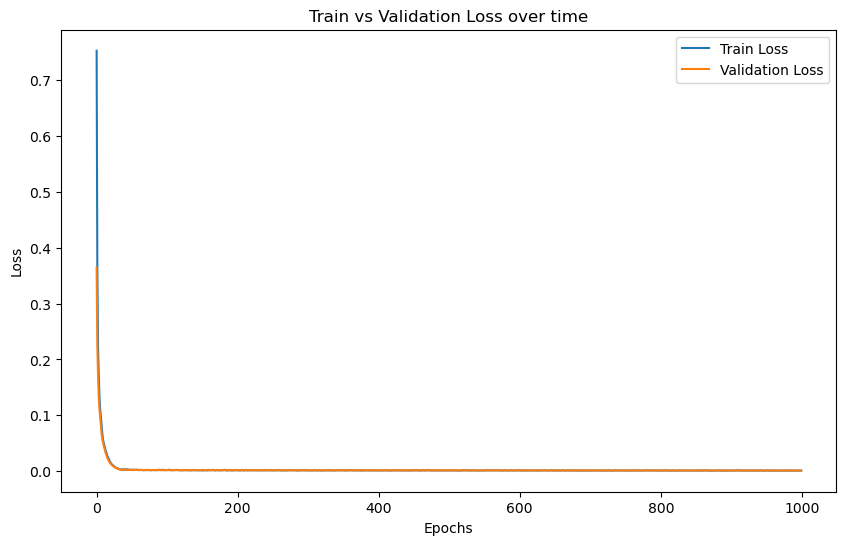

In [21]:
# Convert the history to a pandas dataframe
df_loss_history = pd.DataFrame(loss_history, columns=['train_loss', 'val_loss'])

# plot train and validation loss
plt.figure(figsize=(10, 6))
plt.plot(df_loss_history['train_loss'], label='Train Loss')
plt.plot(df_loss_history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss over time')
plt.legend()
plt.show()


### Evaluation

In [22]:
test_true = test_lmrk
test_pred = model.predict(test_img)

print("Cosine Similarity: ", cosine_loss(test_true, test_pred).numpy())

Cosine Similarity:  0.001098156


### visualize result

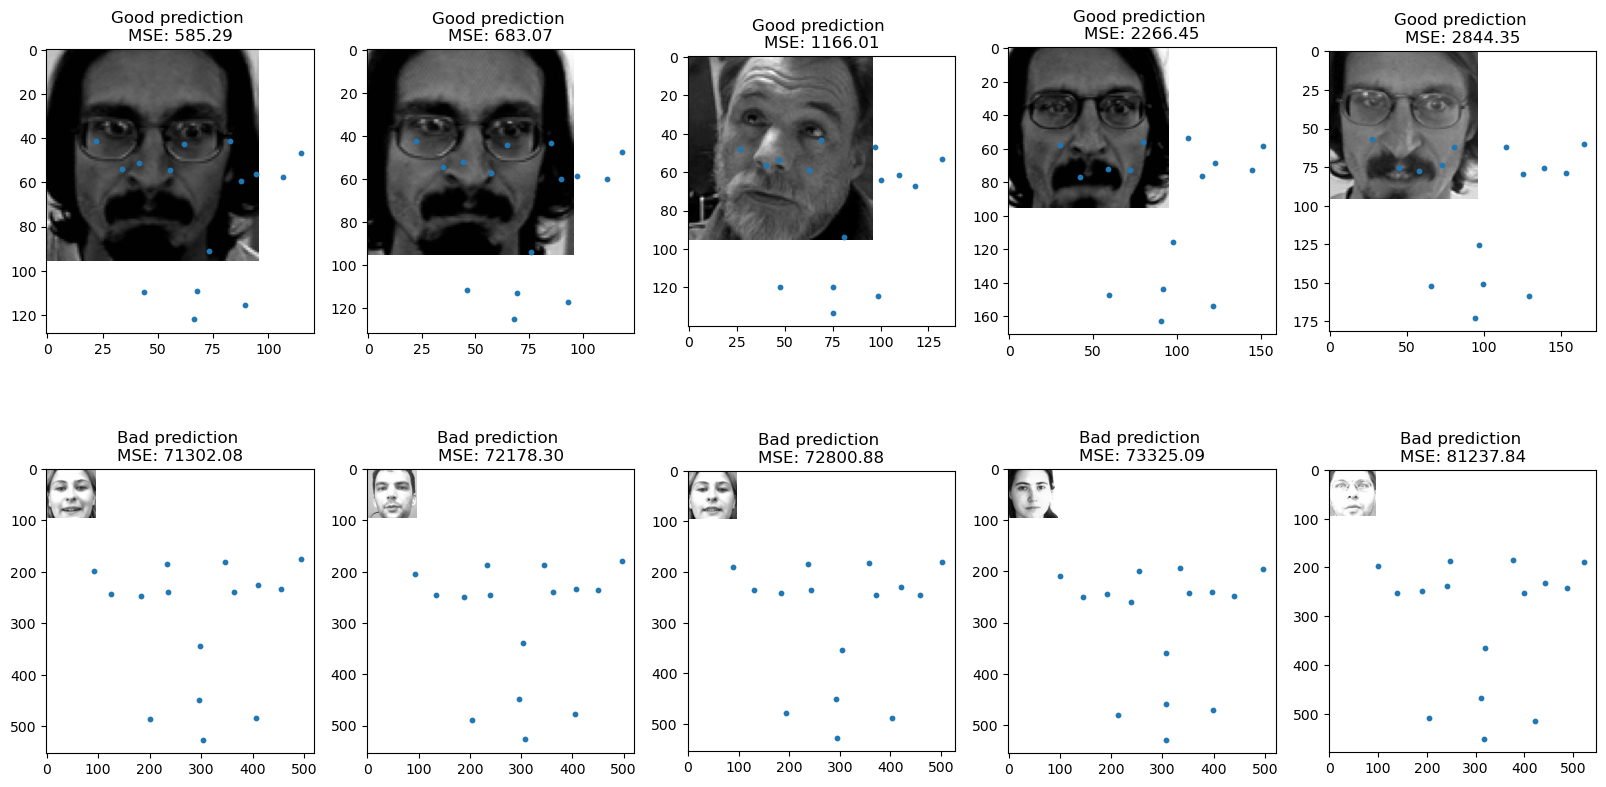

In [23]:
def plot_sample(image, landmarks, ax):
    ax.imshow(image, cmap='gray')
    landmarks = np.reshape(landmarks, (-1, 2)) # reshape to (15, 2)
    ax.scatter(landmarks[:, 0], landmarks[:, 1], marker='o', s=10)

# suppose we have some predictions and ground truth data
predictions = model.predict(test_img)
ground_truth = test_lmrk  # assume this exists

errors = np.mean(np.square(predictions - ground_truth), axis=1)
sorted_indices = np.argsort(errors)

# Indices of good predictions
good_indices = sorted_indices[:5]  

# Indices of bad predictions
bad_indices = sorted_indices[-5:]  

fig = plt.figure(figsize=(20,10))
for i in range(5):
    # Good predictions
    ax = fig.add_subplot(2, 5, i+1)
    plot_sample(test_img[good_indices[i]], predictions[good_indices[i]], ax)
    ax.set_title("Good prediction \nMSE: {:.2f}".format(errors[good_indices[i]]))

    # Bad predictions
    ax = fig.add_subplot(2, 5, i+6)
    plot_sample(test_img[bad_indices[i]], predictions[bad_indices[i]], ax)
    ax.set_title("Bad prediction \nMSE: {:.2f}".format(errors[bad_indices[i]]))

plt.show()
